# O incidente de evaporação do inventário

Você foi contratado para sua primeira investigação. A [COO](https://en.wikipedia.org/wiki/Chief_operating_officer) de uma empresa ouviu rumores sobre irregularidades no inventário. Nada específico, mas o suficiente para deixá-la curiosa.

Você solicitou uma cópia dos dados do sistema SAP da empresa. Você se concentra nos **documentos materiais**.

Seu objetivo é analisar os dados para identificar e entender as irregularidades. **Você pode estabelecer evidências suficientes para fraude?**

## Configuração

Algumas inicializações tornam a vida mais facil!!!

In [1]:
# Permite multiplas saídas para cada célula
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# Mostrar gráficos 
import matplotlib.pyplot as plt
import seaborn as sns
# Bibliotecas para manipulação dos dados
import pandas as pd
import numpy as np
# Formatar número sem decimais
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# Para mostrar os gráficos dentro do notebook
%matplotlib inline 

Usamos as seguintes bibliotecas:
* [Pandas](https://pandas.pydata.org) é o pacote mais importante na análise de dados.
* [Numpy](https://www.numpy.org) usada principalmente para realizar cálculos em Arrays Multidimensionais
* [Matplotlib](https://matplotlib.org/) O Matplotlib é uma biblioteca de plotagem para a linguagem de programação Python e sua extensão de matemática numérica NumPy.
* [Seaborn](https://seaborn.pydata.org/) O Seaborn é uma biblioteca de visualização de dados Python baseada no matplotlib. Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.

Você recebeu duas tabelas do sistema SAP, que contêm as informações dos **movimentos de materiais** da empresa:

1. Detalhes do cabeçalho do documento material. `MKPF`.
2. Detalhes do item do documento material são armazenadas na tabela `MSEG`.

In [2]:
# Carregando os datasets
mkpf = pd.read_csv('MKPK_EI.csv')
mseg = pd.read_csv('MSEG_EI.csv', low_memory=False)

## Entendendo as tabelas

In [3]:
mkpf.head() # a função head mostra por padrão as 5 primeiras linhas do dataset. Você pode escolher quantas linhas mostrar
# digitando a quantidade desejada dentro do parênteses.

,Unnamed: 0,MANDT,MBLNR,MJAHR,VGART,BLART,BLAUM,BLDAT,BUDAT,CPUDT,...,EXNUM,SPE_BUDAT_UHR,SPE_BUDAT_ZONE,LE_VBELN,SPE_LOGSYS,SPE_MDNUM_EWM,GTS_CUSREF_NO,FLS_RSTO,MSR_ACTIVE,KNUMV
0,0,375,5000000010,2017,WE,WE,PR,1/24/17,1/24/17,1/24/17,...,nan,0:00:00,nan,nan,nan,nan,nan,nan,nan,nan
1,1,375,5000000011,2017,WE,WE,PR,1/24/17,1/24/17,1/24/17,...,nan,0:00:00,nan,nan,nan,nan,nan,nan,nan,nan
2,2,375,5000000012,2017,WE,WE,PR,1/24/17,1/24/17,1/24/17,...,nan,0:00:00,nan,nan,nan,nan,nan,nan,nan,nan
3,3,375,5000000013,2017,WE,WE,PR,1/24/17,1/24/17,1/24/17,...,nan,0:00:00,nan,nan,nan,nan,nan,nan,nan,nan
4,4,375,5000000014,2017,WE,WE,PR,1/24/17,1/24/17,1/24/17,...,nan,0:00:00,nan,nan,nan,nan,nan,nan,nan,nan


In [4]:
mseg.head()

,MANDT,MBLNR,MJAHR,ZEILE,LINE_ID,PARENT_ID,LINE_DEPTH,MAA_URZEI,BWART,XAUTO,...,FSH_UMSEA,FSH_UMCOLL,FSH_UMTHEME,SGT_CHINT,OINAVNW,OICONDCOD,CONDI,WRF_CHARSTC1,WRF_CHARSTC2,WRF_CHARSTC3
0,375,5000000010,2017,1,1,0,0,0,101,nan,...,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan
1,375,5000000011,2017,1,1,0,0,0,101,nan,...,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan
2,375,5000000012,2017,1,1,0,0,0,101,nan,...,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan
3,375,5000000013,2017,1,1,0,0,0,101,nan,...,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan
4,375,5000000014,2017,1,1,0,0,0,101,nan,...,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan


In [5]:
print('A Tabela mkpf contém {} linhas e {} colunas'.format(mkpf.shape[0],mkpf.shape[1]))
print('A Tabela mseg contém {} linhas e {} colunas'.format(mseg.shape[0],mseg.shape[1]))

A Tabela mkpf contém 4409 linhas e 34 colunas
A Tabela mseg contém 4412 linhas e 209 colunas


### A tabela MKPF 

Para o nosso propósito, usaremos as seguintes colunas da tabela`MKPF`:

* `MBLNR` - Contém o número do documento do material.

* `USNAM` - Contém o funcionário do estoque que lançou o documento do material.

### A tabela MSEG 

Para o nosso propósito, usaremos as seguintes colunas da tabela `MSEG`:
* `MBLNR` - Contém o número do documento do material.
* `BWART` - Contém código com o tipo de movimentação. Este [link](https://wiki.scn.sap.com/wiki/display/ERPLO/Movement+types) contém informações sobre os tipos de movimento.
* `MATNR` - Contém a identificação do material movimentado.
* `LGORT` - Contém o local de armazenamento.
* `WERKS` - Contém as localizações das fábricas da empresa.
* `DMBTR` - Contém o valor do material movimentado.
* `MENGE` - Contém o volume em unidades do material movimentado. 

## Entendendo a empresa

Após uma reunião, você entende que a empresa possui quatro localizações:

* `DL00` - a fábrica em Dallas, TX
* `MI00` - a fábrica em Miami, FL
* `SD00` - a fábrica em San Diego, CA
* `SC00` - a fábrica em Santa Clara, CA

Além disso, a empresa possui os seguintes grupos de matérias-primas em seus locais de armazenamento (RM00) nos locais da empresa US00. Você mantém um registro dos grupos nas seguintes variáveis.

**Materiais Maravilhosos:**
* `ADAMANTIUM`
* `CARBONITE`
* `KRYPTONITE`

In [6]:
marav = ['ADAMANTIUM', 'CARBONITE', 'KRYPTONITE']

**Metais chatos:**
* `GOLD` 
* `IRON`
* `PALLADIUM`
* `SILVER`

In [7]:
chato = ['GOLD', 'IRON', 'PALLADIUM', 'SILVER']

**Gemas:**
* `ANGOLAN AMETHYST`
* `AUSTRALIAN AMETHYST`
* `BOTSWANA BLACK PE`
* `BRITAIN BLACK PEAR`
* `CANADIAN CRYSTAL`
* `CONGOCRYSTAL`
* `DIAMOND`
* `ROMANIAN RUBY`
* `RUBY`
* `RUSSIAN RUBY`
* `SA SAPPHIRE`
* `SWISS SAPPHIRE`

In [8]:
gemas = ['ANGOLAN AMETHYST','AUSTRALIAN AMETHYST', 'BOTSWANA BLACK PE',\
        'BRITAIN BLACK PEAR', 'CANADIAN CRYSTAL', 'CONGOCRYSTAL', \
        'DIAMOND', 'ROMANIAN RUBY', 'RUBY', \
        'RUSSIAN RUBY', 'SA SAPPHIRE','SWISS SAPPHIRE']


**Essenciais:**
* `CHRONIUM`
* `CONCRETE`
* `ICAN HEADMASK`
* `MAGICDUST`
* `ORANGE`
* `PAPER`
* `ROSE ESSENTIAL OIL`
* `TEST`
* `WALLET`

In [9]:
essenciais = ['CHRONIUM', 'CONCRETE',  'ICAN HEADMASK', \
              'MAGICDUST', 'ORANGE',  'PAPER', \
              'ROSE ESSENTIAL OIL',  'TEST', 'WALLET']

**Consumíveis:**
* `AAA LUBE` 
* `BLUEPAINT`
* `BOLT1000`
* `HEXNT`
* `LIQUID`
* `ZTESTHEXNT`

In [10]:
Consumiveis = ['AAA LUBE', 'BLUEPAINT', 'BOLT1000', \
               'HEXNT','LIQUID','ZTESTHEXNT']

## Sua Investigação

### Reduzir as tabelas para as colunas relevantes

**Seu objetivo:** Concentre-se nas colunas que são importantes para sua investigação.

In [11]:
mseg = mseg.loc[:,['MBLNR','BWART','MATNR','WERKS','LGORT','DMBTR','MENGE']]

In [12]:
mseg.head()

,MBLNR,BWART,MATNR,WERKS,LGORT,DMBTR,MENGE
0,5000000010,101,KRYPTONITE,DL00,RM00,100000.0000,9983
1,5000000011,101,KRYPTONITE,DL00,RM00,100000.0000,4148
2,5000000012,101,KRYPTONITE,DL00,RM00,200000.0000,4058
3,5000000013,101,KRYPTONITE,DL00,RM00,1000000.0000,17255
4,5000000014,101,ICAN HEADMASK,DL00,RM00,1000000.0000,1010


In [13]:
mkpf = mkpf.loc[:,['MBLNR', 'USNAM']]

In [14]:
mkpf.head()

,MBLNR,USNAM
0,5000000010,GBI-028
1,5000000011,GBI-038
2,5000000012,GBI-012
3,5000000013,GBI-028
4,5000000014,GBI-038


In [15]:
# Incluir na tabela mseg a coluna "USNAM" ta tabela mkpf, através da função merge()
mseg = pd.merge(mseg, mkpf, how='left', on='MBLNR',suffixes=('_mseg', '_mkpf'))
mseg.head()

,MBLNR,BWART,MATNR,WERKS,LGORT,DMBTR,MENGE,USNAM
0,5000000010,101,KRYPTONITE,DL00,RM00,100000.0000,9983,GBI-028
1,5000000011,101,KRYPTONITE,DL00,RM00,100000.0000,4148,GBI-038
2,5000000012,101,KRYPTONITE,DL00,RM00,200000.0000,4058,GBI-012
3,5000000013,101,KRYPTONITE,DL00,RM00,1000000.0000,17255,GBI-028
4,5000000014,101,ICAN HEADMASK,DL00,RM00,1000000.0000,1010,GBI-038


### Inclua as informações do grupo de materiais na coluna `MATNR`

In [16]:
mseg['GRUPO'] = 'marav'
mseg.loc[mseg['MATNR'].isin(chato), 'GRUPO'] = 'chato'
mseg.loc[mseg['MATNR'].isin(gemas), 'GRUPO'] = 'gemas'
mseg.loc[mseg['MATNR'].isin(essenciais), 'GRUPO'] = 'essenciais'
mseg.loc[mseg['MATNR'].isin(Consumiveis), 'GRUPO'] = 'Consumiveis'
mseg.head()

,MBLNR,BWART,MATNR,WERKS,LGORT,DMBTR,MENGE,USNAM,GRUPO
0,5000000010,101,KRYPTONITE,DL00,RM00,100000.0000,9983,GBI-028,marav
1,5000000011,101,KRYPTONITE,DL00,RM00,100000.0000,4148,GBI-038,marav
2,5000000012,101,KRYPTONITE,DL00,RM00,200000.0000,4058,GBI-012,marav
3,5000000013,101,KRYPTONITE,DL00,RM00,1000000.0000,17255,GBI-028,marav
4,5000000014,101,ICAN HEADMASK,DL00,RM00,1000000.0000,1010,GBI-038,essenciais


### Desenvolver uma visão geral dos movimentos dos materiais

**Seu objetivo:** Identificar possíveis irregularidades nos dados do movimento do material.

Pense nas seguintes linhas:

* Quais são as diferenças entre os locais?
* Quais são as diferenças entre os tipos de movimento?
* Quais são as relações entre os tipos de movimento?

**Observe:** Você não pode ter números como cabeçalhos de coluna.

Antes de fazer a próxima transformação, cabe explicar a codificação.
Como sabemos, a coluna 'BWART' contém o código com o tipo de movimentação do item, portanto vamos aos seus respectivos significados:

**`Cod 101`** - Entrada de mercadorias por pedido ou por ordem, para esse código usaremos o rótulo **EMP**.

**`Cod 261`** - Saída de mercadorias por ordem. Incluem-se aqui todas as retiradas de material por ordens (p.ex. ordem de produção, ordem de manutenção), com exceção de ordens do cliente, para esse código usaremos o rótulo **SMP**.

**`Cod 333`** - Retirada de amostra do estoque de utilização livre. A amostra apresenta um efeito destrutivo, ou seja, a retirada possui os mesmos efeitos que uma sucata, para esse código usaremos o rótulo **RAE**.

**`Cod 551`** - Refugo de estoque de utilização livre, para esse código usaremos o rótulo **REI**.

In [17]:
mseg['BWART']=mseg['BWART'].map({101:'EMP',261:'SMP',333:'RAE',551:'REI'})
mseg.head()

,MBLNR,BWART,MATNR,WERKS,LGORT,DMBTR,MENGE,USNAM,GRUPO
0,5000000010,EMP,KRYPTONITE,DL00,RM00,100000.0000,9983,GBI-028,marav
1,5000000011,EMP,KRYPTONITE,DL00,RM00,100000.0000,4148,GBI-038,marav
2,5000000012,EMP,KRYPTONITE,DL00,RM00,200000.0000,4058,GBI-012,marav
3,5000000013,EMP,KRYPTONITE,DL00,RM00,1000000.0000,17255,GBI-028,marav
4,5000000014,EMP,ICAN HEADMASK,DL00,RM00,1000000.0000,1010,GBI-038,essenciais


Tabela para sumarizar os totais de unidades movimentadas por localização e grupo.

In [18]:
mseg_pivot = mseg.pivot_table(index=['WERKS','GRUPO'], columns='BWART', values='MENGE', aggfunc='sum').reset_index()
mseg_pivot

BWART,WERKS,GRUPO,EMP,RAE,REI,SMP
0,DL00,Consumiveis,473489,11664,6649,417608
1,DL00,chato,80115,1276,2228,70819
2,DL00,essenciais,165180,3616,3825,146107
3,DL00,gemas,41038,908,636,37093
4,DL00,marav,988490,9838,9368,881757
5,MI00,Consumiveis,476189,9353,13516,438888
6,MI00,chato,84868,1350,866,77455
7,MI00,essenciais,160562,2623,4596,146846
8,MI00,gemas,36279,470,393,33467
9,MI00,marav,1043465,10107,42878,951444


Inclusão das colunas "UTILIZAÇÃO","REFUGO" e "AMOSTRAGEM" que mostra o percentual com relação as Entradas Mercadoria para Pedidos(EMP).

In [19]:
mseg_pivot['UTILIZAÇÃO'] = mseg_pivot['SMP'] / mseg_pivot['EMP']
mseg_pivot['REFUGO'] = mseg_pivot['REI'] / mseg_pivot['EMP']
mseg_pivot['AMOSTRAGEM'] = mseg_pivot['RAE'] / mseg_pivot['EMP']
mseg_pivot

BWART,WERKS,GRUPO,EMP,RAE,REI,SMP,UTILIZAÇÃO,REFUGO,AMOSTRAGEM
0,DL00,Consumiveis,473489,11664,6649,417608,0.8820,0.0140,0.0246
1,DL00,chato,80115,1276,2228,70819,0.8840,0.0278,0.0159
2,DL00,essenciais,165180,3616,3825,146107,0.8845,0.0232,0.0219
3,DL00,gemas,41038,908,636,37093,0.9039,0.0155,0.0221
4,DL00,marav,988490,9838,9368,881757,0.8920,0.0095,0.0100
5,MI00,Consumiveis,476189,9353,13516,438888,0.9217,0.0284,0.0196
6,MI00,chato,84868,1350,866,77455,0.9127,0.0102,0.0159
7,MI00,essenciais,160562,2623,4596,146846,0.9146,0.0286,0.0163
8,MI00,gemas,36279,470,393,33467,0.9225,0.0108,0.0130
9,MI00,marav,1043465,10107,42878,951444,0.9118,0.0411,0.0097


In [20]:
# Ficando apenas com as colunas importantes
h = mseg_pivot.groupby(['WERKS', 'GRUPO'])\
[['UTILIZAÇÃO', 'REFUGO', 'AMOSTRAGEM']].mean().reset_index().\
sort_values('AMOSTRAGEM', ascending=False)
h

BWART,WERKS,GRUPO,UTILIZAÇÃO,REFUGO,AMOSTRAGEM
14,SC00,marav,0.8908,0.0190,0.0254
11,SC00,chato,0.8849,0.0451,0.0250
0,DL00,Consumiveis,0.8820,0.0140,0.0246
3,DL00,gemas,0.9039,0.0155,0.0221
2,DL00,essenciais,0.8845,0.0232,0.0219
17,SD00,essenciais,0.9206,0.0207,0.0205
16,SD00,chato,0.8860,0.0253,0.0197
5,MI00,Consumiveis,0.9217,0.0284,0.0196
18,SD00,gemas,0.9334,0.0143,0.0173
7,MI00,essenciais,0.9146,0.0286,0.0163


In [21]:
# Em ordem crescente da coluna "BWART"
h = mseg_pivot.groupby(['WERKS', 'GRUPO'])\
[['UTILIZAÇÃO', 'REFUGO', 'AMOSTRAGEM']].mean().reset_index()
h

BWART,WERKS,GRUPO,UTILIZAÇÃO,REFUGO,AMOSTRAGEM
0,DL00,Consumiveis,0.8820,0.0140,0.0246
1,DL00,chato,0.8840,0.0278,0.0159
2,DL00,essenciais,0.8845,0.0232,0.0219
3,DL00,gemas,0.9039,0.0155,0.0221
4,DL00,marav,0.8920,0.0095,0.0100
5,MI00,Consumiveis,0.9217,0.0284,0.0196
6,MI00,chato,0.9127,0.0102,0.0159
7,MI00,essenciais,0.9146,0.0286,0.0163
8,MI00,gemas,0.9225,0.0108,0.0130
9,MI00,marav,0.9118,0.0411,0.0097


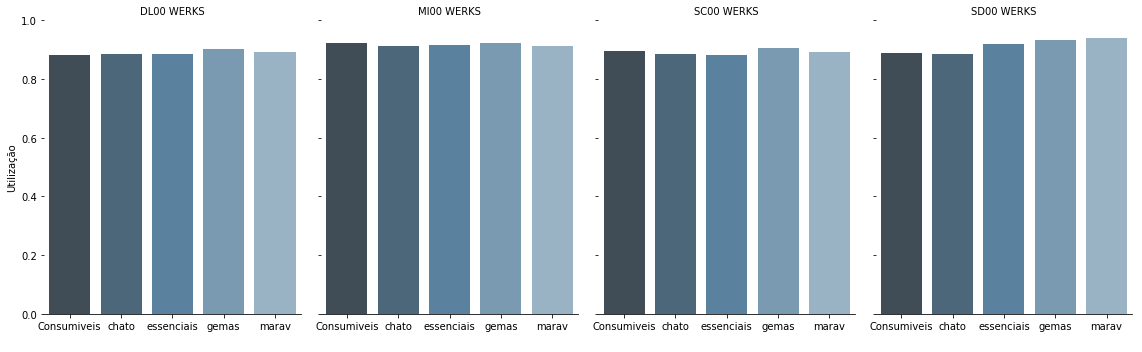

In [22]:
util = sns.catplot(x="GRUPO", y="UTILIZAÇÃO", col="WERKS",
                     data=h, saturation=.5,
                     kind="bar", ci= None, aspect=.8, palette="Blues_d")
(util.set_axis_labels(" ","Utilização")
 .set_xticklabels(["Consumiveis", "chato", "essenciais", "gemas", "marav"])
 .set_titles("{col_name} {col_var}")
 .set(ylim=(0, 1))
 .despine(left=True))  


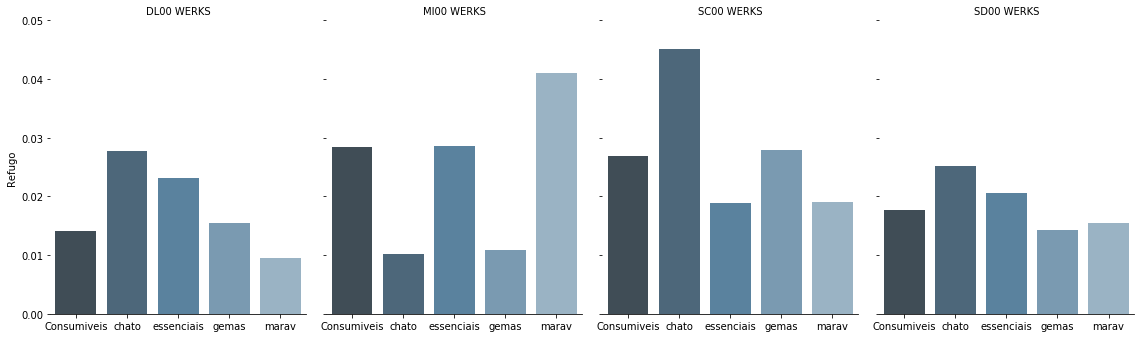

In [23]:
refugo = sns.catplot(x="GRUPO", y="REFUGO", col="WERKS",
                     data=h, saturation=.5,
                     kind="bar", ci= None, aspect=.8, palette="Blues_d")
(refugo.set_axis_labels(" ","Refugo")
 .set_xticklabels(["Consumiveis", "chato", "essenciais", "gemas", "marav"])
 .set_titles("{col_name} {col_var}")
 .set(ylim=(0, .05))
 .despine(left=True))  

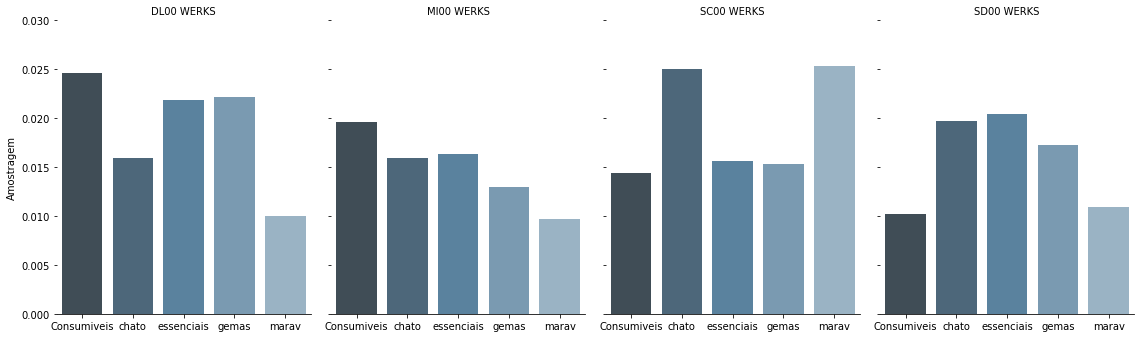

In [24]:
amostragem = sns.catplot(x="GRUPO", y="AMOSTRAGEM", col="WERKS",
                     data=h, saturation=.5,
                     kind="bar", ci= None, aspect=.8, palette="Blues_d")
(amostragem.set_axis_labels(" ","Amostragem")
 .set_xticklabels(["Consumiveis", "chato", "essenciais", "gemas", "marav"])
 .set_titles("{col_name} {col_var}")
 .set(ylim=(0, .03))
 .despine(left=True))  

## Qual o indício de fraude?

In [25]:
# Agrupando por localização, Grupo e tipo de movimentação, agregando pela soma das quantidades e demonstrando quantos usuários
# efetuaram a mesma operação.
g = mseg.groupby(['WERKS','GRUPO','BWART']).agg({'MENGE':'sum','USNAM':'unique'}).reset_index()
g

,WERKS,GRUPO,BWART,MENGE,USNAM
0,DL00,Consumiveis,EMP,473489,"[GBI-038, GBI-028, GBI-012]"
1,DL00,Consumiveis,RAE,11664,"[GBI-012, GBI-038, GBI-028]"
2,DL00,Consumiveis,REI,6649,"[GBI-028, GBI-038, GBI-012]"
3,DL00,Consumiveis,SMP,417608,"[GBI-038, GBI-028, GBI-012]"
4,DL00,chato,EMP,80115,"[GBI-038, GBI-028, GBI-012]"
5,DL00,chato,RAE,1276,"[GBI-028, GBI-038, GBI-012]"
6,DL00,chato,REI,2228,"[GBI-012, GBI-038, GBI-028]"
7,DL00,chato,SMP,70819,"[GBI-012, GBI-038, GBI-028]"
8,DL00,essenciais,EMP,165180,"[GBI-038, GBI-012, GBI-028]"
9,DL00,essenciais,RAE,3616,"[GBI-012, GBI-028, GBI-038]"


In [26]:
# Criando a coluna 'USANAM_NO' para demonstrar quantos usuários efetuou cada operação.
g['USNAM_NO'] = g['USNAM'].apply(lambda x: len(x))
g

,WERKS,GRUPO,BWART,MENGE,USNAM,USNAM_NO
0,DL00,Consumiveis,EMP,473489,"[GBI-038, GBI-028, GBI-012]",3
1,DL00,Consumiveis,RAE,11664,"[GBI-012, GBI-038, GBI-028]",3
2,DL00,Consumiveis,REI,6649,"[GBI-028, GBI-038, GBI-012]",3
3,DL00,Consumiveis,SMP,417608,"[GBI-038, GBI-028, GBI-012]",3
4,DL00,chato,EMP,80115,"[GBI-038, GBI-028, GBI-012]",3
5,DL00,chato,RAE,1276,"[GBI-028, GBI-038, GBI-012]",3
6,DL00,chato,REI,2228,"[GBI-012, GBI-038, GBI-028]",3
7,DL00,chato,SMP,70819,"[GBI-012, GBI-038, GBI-028]",3
8,DL00,essenciais,EMP,165180,"[GBI-038, GBI-012, GBI-028]",3
9,DL00,essenciais,RAE,3616,"[GBI-012, GBI-028, GBI-038]",3


In [27]:
g[g['USNAM_NO']<3]

,WERKS,GRUPO,BWART,MENGE,USNAM,USNAM_NO
57,SC00,marav,RAE,20929,[GBI-073],1


**Reflita:** Você consegue explicar o indício de fraude?

Cabe frisar a palavra 'indício', pois como auditor, esse tipo de análise serve apenas para apontar uma anormalidade dentro do fluxo normal do que as operações nesses datasets demonstram. Outras análises devem ser feitas concomitantemente e obviamente o levantamento de documentos auxiliares e probatórios devem ser feitos para se chegar a alguma conclusão.

Os datasets aqui utilizados serão disponibilizados para que você também possa análisar utilizando-se das suas próprias ferramentas de análises e chegarem as mesmas conclusões, ou quem sabe, a novas conclusões e pontos de vista na qual este que vos escreve ficaria feliz em conhecer.

# OBRIGADO